In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/var/folders/nh/wzpnhgnd3b120fs0pfgmyhfr0000gn/T/ipykernel_55264/2147853193.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/nh/wzpnhgnd3b120fs0pfgmyhfr0000gn/T/ipykernel_55264/2147853193.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# Preproccessing

In [2]:
#KOREAN AIR-------------------------------------------------------------------
ke = pd.read_csv('/Users/kalebmckenzie/Documents/Work Documents/Backend Dashboard/KoreanAir18.csv')
ke['BOOKING DATE'] = pd.to_datetime(ke['BOOKING DATE'])
ke['DEPARTURE DATE'] = pd.to_datetime(ke['DEPARTURE DATE'])
ke['total_fare'] = ke['ADT'] + ke['CHD']
offices = ['ATL1S21GX']
ke = ke.loc[ke['BOOKED OFFICE'].isin(offices)]
ke = ke.loc[ke['BOOKING DATE'] >= '2018-01-01']
start2 = '2018-01-01'
end2 = '2022-03-31'
ke1 = ke.loc[(ke['DEPARTURE DATE'] >= start2) & (ke['DEPARTURE DATE'] <= end2)].copy()

data1 = ke1[['DEPARTURE DATE','total_fare','BOOKED OFFICE']]
data1 = data1.set_index('DEPARTURE DATE')

data1 = data1.sort_values(by="DEPARTURE DATE")

data1 = data1['2018-01-01':'2022-03-31'].resample('W').sum()
data1['total_fare'] = data1['total_fare'].astype(int)

#FRENCH BEE-------------------------------------------------------------------
bf = pd.read_csv('/Users/kalebmckenzie/Documents/Work Documents/Backend Dashboard/FrenchBee18-22.csv')
bf['BOOKING DATE'] = pd.to_datetime(bf['BOOKING DATE'])
bf['DEPARTURE DATE'] = pd.to_datetime(bf['DEPARTURE DATE'])
bf['total_fare'] = bf['ADT'] + bf['CHD']
offices = ['ATL1S211S','HNL1S210I']
bf = bf.loc[bf['BOOKED OFFICE'].isin(offices)]
bf = bf.loc[bf['BOOKING DATE'] >= '2018-01-01']
start3 = '2018-01-01'
end3 = '2022-04-01'
bf1 = bf.loc[(bf['DEPARTURE DATE'] >= start3) & (bf['DEPARTURE DATE'] <= end3)].copy()

data2 = bf1[['DEPARTURE DATE','ADT','BOOKED OFFICE']]
data2 = data2.set_index('DEPARTURE DATE')

data2 = data2.sort_values(by="DEPARTURE DATE")

data2 = data2['2018-01-01':'2022-04-01'].resample('W').sum()
data2['ADT'] = data2['ADT'].astype(int)

#AIRLINE Y VALUES-------------------------------------------------------------------
ke_y = data1['total_fare']
bf_y = data2['ADT']

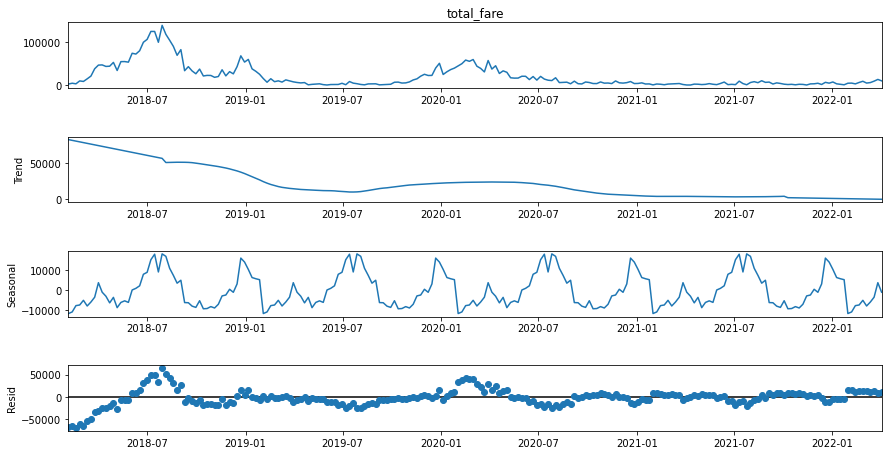

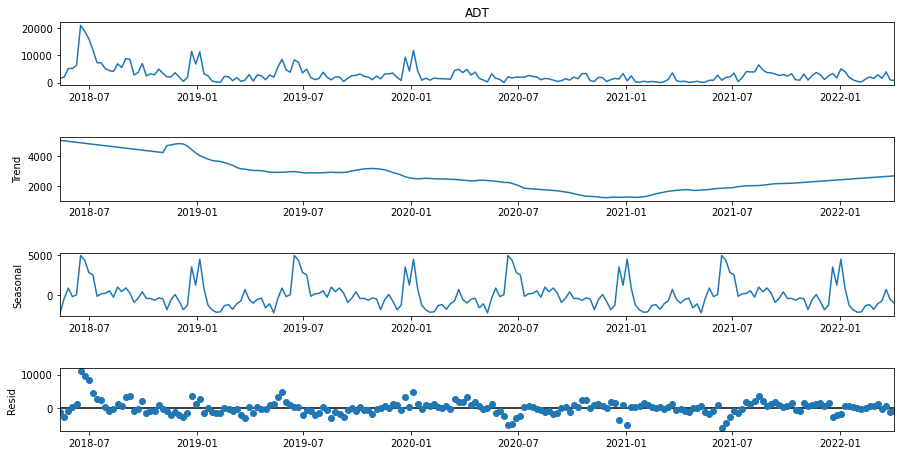

 > Is the raw data stationary ?
Test statistic = -2.429
P-value = 0.134
Critical values :
	1%: -3.461878735881654 - The data is not stationary with 99% confidence
	5%: -2.875403665910809 - The data is not stationary with 95% confidence
	10%: -2.574159410430839 - The data is not stationary with 90% confidence
 > Is the raw data stationary ?
Test statistic = -4.826
P-value = 0.000
Critical values :
	1%: -3.4631437906252636 - The data is  stationary with 99% confidence
	5%: -2.8759570379821047 - The data is  stationary with 95% confidence
	10%: -2.574454682874228 - The data is  stationary with 90% confidence
 > Is the de-trended data stationary ?
Test statistic = -4.043
P-value = 0.001
Critical values :
	1%: -3.4633090972761744 - The data is  stationary with 99% confidence
	5%: -2.876029332045744 - The data is  stationary with 95% confidence
	10%: -2.5744932593252643 - The data is  stationary with 90% confidence
 > Is the de-trended data stationary ?
Test statistic = -6.700
P-value = 0.00

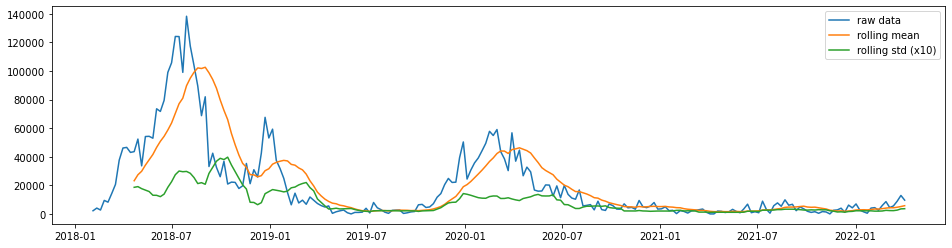

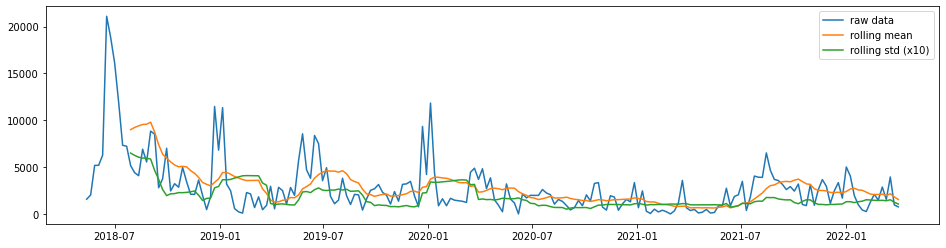

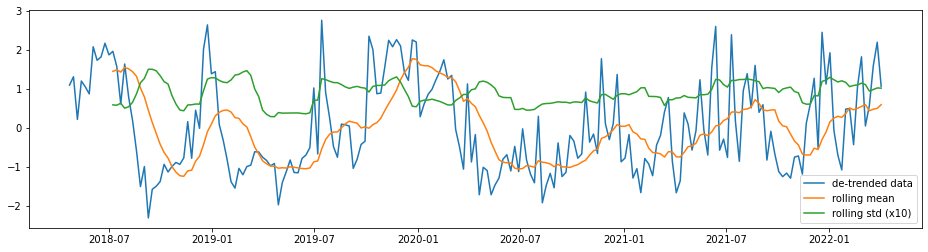

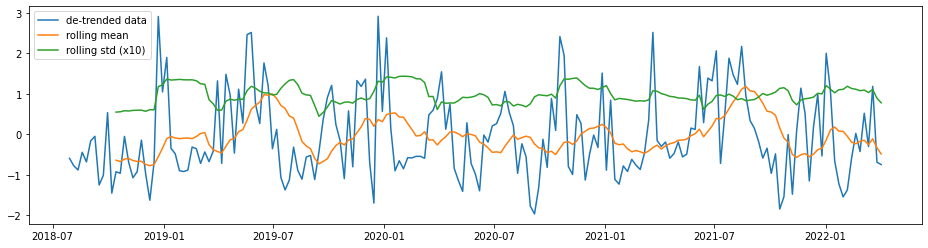

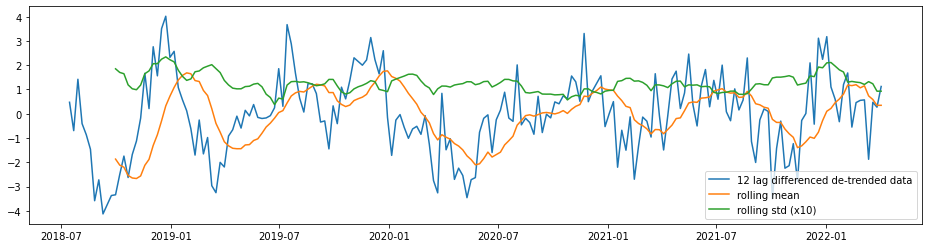

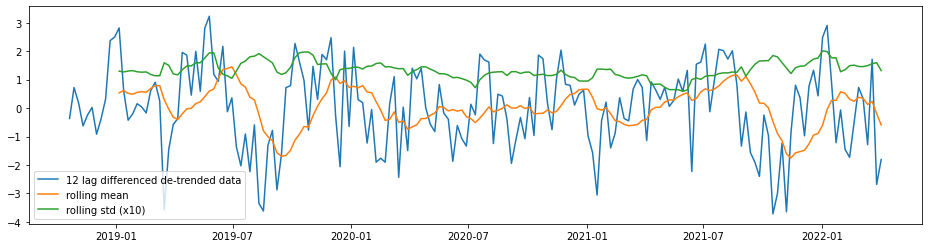

In [4]:
#----------------------------------------
#SEASONAL DECOMPOSE FUNCTION
import statsmodels.api as sm
def seasonal_decompose(y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(ke_y)
seasonal_decompose(bf_y)

#----------------------------------------
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format

test_stationarity(ke_y,'raw data')
test_stationarity(bf_y,'raw data')

#----------------------------------------
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(ke_y,'raw data')
ADF_test(bf_y,'raw data')

ke_y_detrend =  (ke_y - ke_y.rolling(window=12).mean())/ke_y.rolling(window=12).std()
bf_y_detrend =  (bf_y - bf_y.rolling(window=12).mean())/bf_y.rolling(window=12).std()

test_stationarity(ke_y_detrend,'de-trended data')
test_stationarity(bf_y_detrend,'de-trended data')
ADF_test(ke_y_detrend,'de-trended data')
ADF_test(bf_y_detrend,'de-trended data')

ke_y_12lag_detrend =  ke_y_detrend - ke_y_detrend.shift(12)
bf_y_12lag_detrend =  bf_y_detrend - bf_y_detrend.shift(12)

test_stationarity(ke_y_12lag_detrend,'12 lag differenced de-trended data')
test_stationarity(bf_y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(ke_y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(bf_y_12lag_detrend,'12 lag differenced de-trended data')


def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                measurement_error=True)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

#--------------------------------------------------------------------

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10867D+00    |proj g|=  4.78292D-01


 This problem is unconstrained.



At iterate    5    f=  7.98085D+00    |proj g|=  1.99670D-02

At iterate   10    f=  7.98049D+00    |proj g|=  1.75430D-03

At iterate   15    f=  7.98013D+00    |proj g|=  6.08576D-03

At iterate   20    f=  7.98008D+00    |proj g|=  3.59389D-05

At iterate   25    f=  7.98007D+00    |proj g|=  1.76747D-03

At iterate   30    f=  7.97916D+00    |proj g|=  1.96581D-02

At iterate   35    f=  7.93054D+00    |proj g|=  7.26778D-02

At iterate   40    f=  7.89351D+00    |proj g|=  2.82534D-02

At iterate   45    f=  7.88641D+00    |proj g|=  8.15435D-03


/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  7.88549D+00    |proj g|=  7.41615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   7.416D-05   7.885D+00
  F =   7.8854946168338005     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.L1                     0.9992      0.040     25.110      0.000       0.921       1.077
ma.L1                    -0.2775      0.065     -4.280      0.000      -0.405      -0.150
a

/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



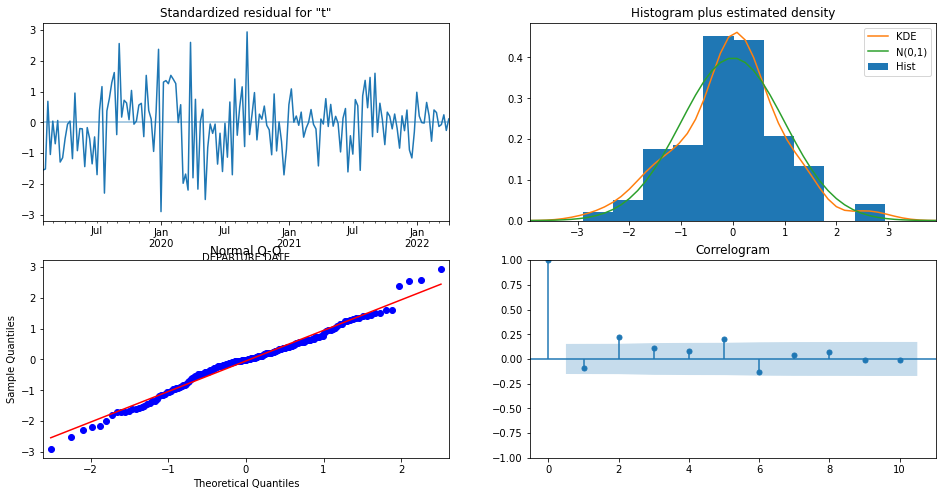

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 4661.88


/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



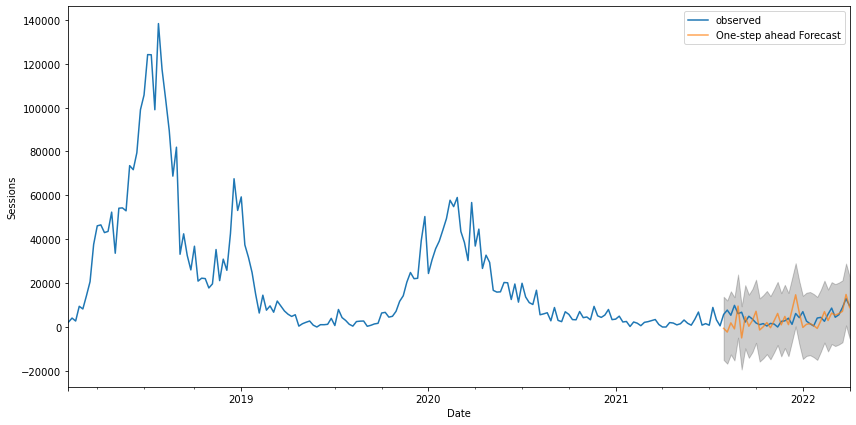

/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 21535.28


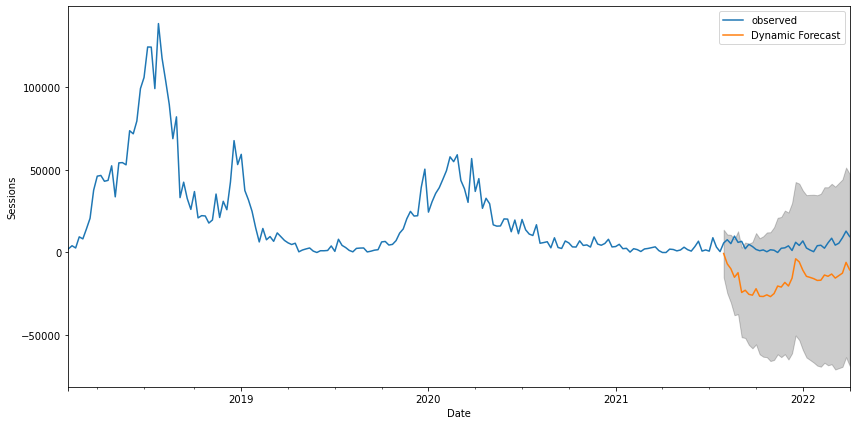

/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.85028D+00    |proj g|=  4.04533D-01

At iterate    5    f=  6.72693D+00    |proj g|=  1.69693D-02

At iterate   10    f=  6.72425D+00    |proj g|=  1.01167D-03

At iterate   15    f=  6.72424D+00    |proj g|=  5.16799D-04

At iterate   20    f=  6.72399D+00    |proj g|=  6.25573D-03

At iterate   25    f=  6.70560D+00    |proj g|=  4.50082D-02

At iterate   30    f=  6.67996D+00    |proj g|=  1.32815D-02

At iterate   35    f=  6.67728D+00    |proj g|=  9.11393D-03

At iterate   40    f=  6.67658D+00    |proj g|=  1.69666D-03

At iterate   45    f=  6.67652D+00    |proj g|=  9.20592D-04


/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  6.67651D+00    |proj g|=  4.79185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   4.792D-04   6.677D+00
  F =   6.6765082728432370     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.L1                     0.7701      0.108      7.133      0.000       0.559       0.982
ma.L1                    -0.3304      0.143     -2.307      0.021      -0.611      -0.050
a

/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



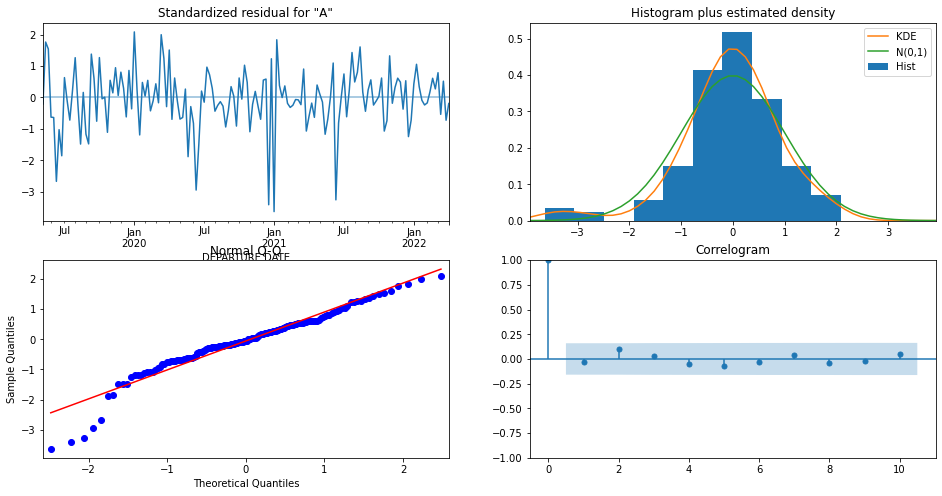

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 968.47


/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



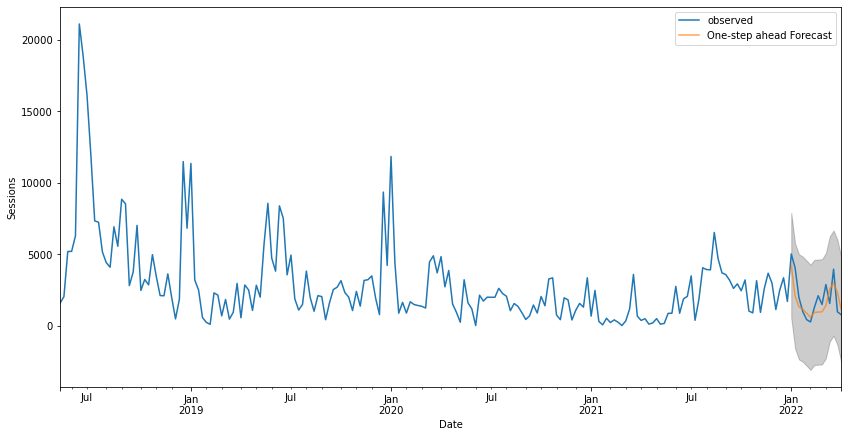

/Users/kalebmckenzie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 1252.53


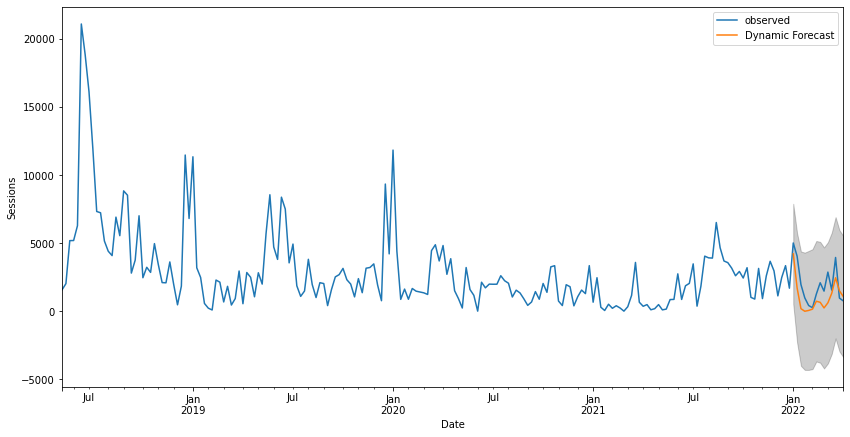

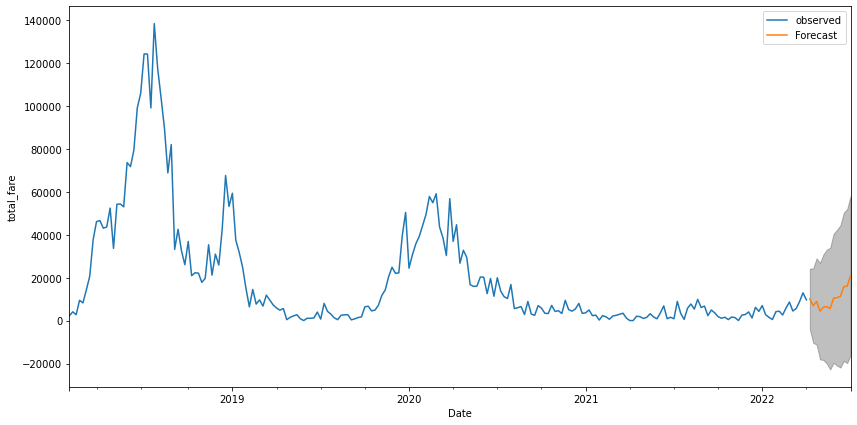

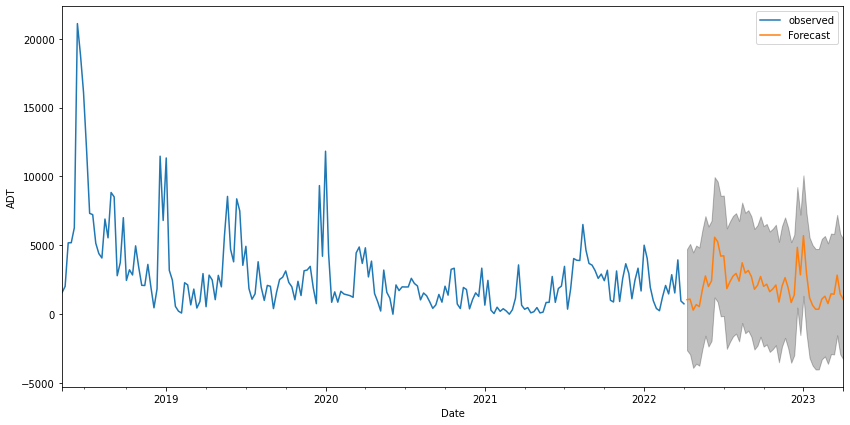

In [13]:
ke_y_train = ke_y[:'2021-07-04'] # dataset to train
ke_y_to_val = ke_y['2021-08-01':] # last X months for kefore  
predict_date_ke = len(ke_y) - len(ke_y[:'2021-08-01'])

bf_y_train = bf_y[:'2021-12-26'] # dataset to train
bf_y_to_val = bf_y['2022-01-02':] # last X months for kefore  
predict_date_bf = len(bf_y) - len(bf_y[:'2022-01-02'])


model_ke = sarima_eva(ke_y,(1, 0, 1),(1, 1, 1, 52),52,'2021-08-01',ke_y_to_val)

model_bf = sarima_eva(bf_y,(1, 0, 1),(1, 1, 1, 52),52,'2022-01-02',bf_y_to_val)

def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

#FORECASTS--------------------------------------------------------------
final_ke = forecast(model_ke,13,ke_y)
final_ke.tail()
final_bf = forecast(model_bf,52,bf_y)
final_bf.tail()





#MORE PROCESSING----------------------------------------------------------
kefore = final_ke[['Date','Predicted_Mean']]
kefore = kefore.rename(columns={'Date':'DEPARTURE DATE', 'Predicted_Mean': 'forecast'})
kefore['forecast'] = kefore['forecast'].astype(int)
kefore = kefore.set_index('DEPARTURE DATE')
korean = data1.append(kefore)
korean['total_fare'] = korean['total_fare'].astype(float)
korean['forecast'] = korean['forecast'].astype(float)


before = final_bf[['Date','Predicted_Mean']]
before = before.rename(columns={'Date':'DEPARTURE DATE', 'Predicted_Mean': 'forecast'})
before['forecast'] = before['forecast'].astype(int)
before = before.set_index('DEPARTURE DATE')
bee = data2.append(before)
bee['ADT'] = bee['ADT'].astype(float)
bee['forecast'] = bee['forecast'].astype(float)

In [22]:
final_bf.head()

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-04-10,1056.40792572,-2621.34122509,4734.15707652
1,2022-04-17,1092.59935003,-2917.18783089,5102.38653096
2,2022-04-24,295.32923001,-3894.96467006,4485.62313008
3,2022-05-01,697.69051189,-3589.77255252,4985.15357629
4,2022-05-08,551.64827645,-3736.27195079,4839.56850368


In [17]:
#Data Processing-------------------------------------------------------

#KOREAN AIR
tke = pd.read_csv('/Users/kalebmckenzie/Documents/Work Documents/Backend Dashboard/KoreanAir18.csv')
tke['BOOKING DATE'] = pd.to_datetime(tke['BOOKING DATE'])
tke['DEPARTURE DATE'] = pd.to_datetime(tke['DEPARTURE DATE'])
tke['total_fare'] = tke['ADT'] + tke['CHD']
offices = ['ATL1S21GX']
tke = tke.loc[tke['BOOKED OFFICE'].isin(offices)]
tke = tke.loc[tke['BOOKING DATE'] >= '2018-01-01']
start2 = '2018-01-01'
end2 = '2022-06-30'
tke1 = tke.loc[(tke['DEPARTURE DATE'] >= start2) & (tke['DEPARTURE DATE'] <= end2)].copy()

tke1 = tke1[['DEPARTURE DATE','total_fare','BOOKED OFFICE']]
tke1 = tke1.set_index('DEPARTURE DATE')

tke1 = tke1.sort_values(by="DEPARTURE DATE")
#tke1.loc[tke1['total fare'] == 0]
tke1 = tke1['2018-01-01':'2022-06-30'].resample('W').sum()
tke1['total_fare'] = tke1['total_fare'].astype(int)


#FRENCH BEE
tbf = pd.read_csv('/Users/kalebmckenzie/Documents/Work Documents/Backend Dashboard/FrenchBee18-22.csv')
tbf['BOOKING DATE'] = pd.to_datetime(tbf['BOOKING DATE'])
tbf['DEPARTURE DATE'] = pd.to_datetime(tbf['DEPARTURE DATE'])
tbf['total_fare'] = tbf['ADT'] + tbf['CHD']
offices = ['ATL1S211S','HNL1S210I']
tbf = tbf.loc[tbf['BOOKED OFFICE'].isin(offices)]
tbf = tbf.loc[tbf['BOOKING DATE'] >= '2018-01-01']
start2 = '2018-01-01'
end2 = '2023-03-31'
tbf1 = tbf.loc[(tbf['DEPARTURE DATE'] >= start2) & (tbf['DEPARTURE DATE'] <= end2)].copy()

tbfx = tbf1[['DEPARTURE DATE','ADT','BOOKED OFFICE']]
tbfx = tbfx.set_index('DEPARTURE DATE')

tbfx = tbfx.sort_values(by="DEPARTURE DATE")
#tbfx.loc[tbfx['total fare'] == 0]
tbfx = tbfx['2018-01-01':'2023-03-31'].resample('W').sum()
tbfx['ADT'] = tbfx['ADT'].astype(int)


In [20]:
#Plotly-----------------------------------------------------------------

colors = {
    'background': '#ECECEC',
    'text': '#323232'
}

#KOREAN AIR-----------------------------------------------------------------
fig = go.Figure()

fig.add_trace(go.Scatter(x=tke1.index, y=tke1['total_fare'],
                    mode='lines',
                    name='Flown'))

fig.add_trace(go.Scatter(x=korean.index, y=korean['forecast'],
                    mode='lines',
                    name='forecast',
                    marker_color= 'green'))

fig.update_layout(plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'])

fig.update_layout(margin={"l": 0, "r": 20, "t": 50, "b": 0})


fig2 = go.Figure()

fig2.add_trace(go.Indicator(
    mode = "number+delta",
    value = korean['forecast']['2022-04-01':'2022-06-30'].sum(),
    number = {'prefix': "$"},
    delta = {'reference': korean['total_fare']['2021-04-01':'2021-06-30'].sum(), 'relative': True},
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text':"KE Forecasted Flown Revenue<br><span style='font-size:0.8em;color:gray'>Compared to</span><br><span style='font-size:0.8em;color:gray'>2021</span>"}))

fig2.add_trace(go.Indicator(
    mode = "number+delta",
    value = tke1['total_fare']['2022-04-01':'2022-06-30'].sum(),
    number = {'prefix': "$"},
    delta = {'reference': korean['forecast']['2022-04-01':'2022-06-30'].sum(), 'relative': True},
    domain = {'x': [0, 0.5], 'y': [0, 1]},
    title = {'text':"KE Actual Flown Revenue<br><span style='font-size:0.8em;color:gray'>Compared to</span><br><span style='font-size:0.8em;color:gray'>Forecast</span>"}))

fig2.add_trace(go.Indicator(
    value = 20000,
    gauge = {
        'axis' : {'visible': False}},
    domain = {'x': [0.5,1], 'y': [0.1, 1]}))

fig2.update_layout(
    paper_bgcolor=colors['background'],
    height=300,
    template = {'data' : {'indicator': [{
        'title': {'text': "Target"},
        'mode' : "number+delta"}]
                         }})
#FRENCH BEE-----------------------------------------------------------------

figf = go.Figure()

figf.add_trace(go.Scatter(x=tbfx.index, y=tbfx['ADT'],
                    mode='lines',
                    name='Flown'))

figf.add_trace(go.Scatter(x=bee.index, y=bee['forecast'],
                    mode='lines',
                    name='forecast',
                    marker_color= 'orange'))

figf.update_layout(plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'])

figf.update_layout(margin={"l": 0, "r": 20, "t": 50, "b": 0})


figf2 = go.Figure()
#FORECASTED COMPARISON
figf2.add_trace(go.Indicator(
    mode = "number+delta",
    value = bee['forecast']['2022-04-01':'2023-04-02'].sum(),
    number = {'prefix': "$"},
    delta = {'reference': tbfx['ADT']['2021-04-01':'2022-04-02'].sum(), 'relative': True},
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text':"BF Forecasted Flown Revenue<br><span style='font-size:0.8em;color:gray'>Compared to</span><br><span style='font-size:0.8em;color:gray'>2021</span>"}))
    
#ACTUAL COMPARISON TO FORECAST
figf2.add_trace(go.Indicator(
    mode = "number+delta",
    value = tbfx['ADT']['2022-04-01':'2023-03-31'].sum(),
    number = {'prefix': "$"},
    delta = {'reference': bee['forecast']['2022-04-01':'2022-05-02'].sum(), 'relative': True},
    domain = {'x': [0, 0.5], 'y': [0, 1]},
    title = {'text':"BF Actual Flown Revenue<br><span style='font-size:0.8em;color:gray'>Compared to</span><br><span style='font-size:0.8em;color:gray'>Forecast</span>"}))

figf2.add_trace(go.Indicator(
    value = 1500000,
    gauge = {
        'axis' : {'visible': False}},
    domain = {'x': [0.5,1], 'y': [0.1, 1]}))

figf2.update_layout(
    paper_bgcolor=colors['background'],
    height=300,
    template = {'data' : {'indicator': [{
        'title': {'text': "Final Target"},
        'mode' : "number+delta"}]
                         }})



#APP SPECIFICATIONS
#--------------------------------------------------------------------------------------------------------------------#

app = JupyterDash(__name__)

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[

    #KOREAN AIR
    html.H1(
        children='Korean Air Backend',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),

    html.Div(children='Forecasts for 2022 In Office ATL1S21GX',style={
        'textAlign': 'center',
        'color': colors['text']
    }),

    dcc.Graph(
        figure=fig
    ),

    dcc.Graph(
        figure=fig2
    ),

    #FRENCH BEE
    html.H1(
        children='French Bee Backend',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),

    html.Div(children='Forecasts for 2022 In Office ATL1S211S, HNL1S210I',style={
        'textAlign': 'center',
        'color': colors['text']
    }),

    dcc.Graph(
        figure=figf
    ),

    dcc.Graph(
        figure=figf2
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


In [4]:
4294375

4294375